# CCD dataset analysis

This notebook aims to assess our model's performances on the dataset CCD. It is applied to the cingulate region.

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/distmap/CCD/runs/right/checkpoint.pt'
model = VAE((1, 40, 128, 128), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Loading of HCP test set

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/CCD/data/"
data_dir = "/neurospin/dico/lguillon/distmap/CCD/data/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))
distmaps = np.load(os.path.join(data_dir, "test_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "test_sub_id.npy"))
print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

(200, 30, 128, 105, 1) (200,)


### Loading of CCD data

In [5]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/CCD"
data_path = "crops/1mm/no_mask"

In [6]:
os.path.join(data_dir, "controls", data_path, "skel_all.npy")

'/neurospin/dico/data/deep_folding/current/datasets/CCD/controls/crops/1mm/no_mask/skel_all.npy'

In [6]:
controls = np.load(os.path.join(data_dir, "controls", data_path, "skel_all.npy"),
                   mmap_mode='r')
filenames_controls = np.load(os.path.join(data_dir, "controls", data_path, "sub_id_skel_all.npy"))

subset_controls = SkeletonDataset(dataframe=controls,
                                 filenames=filenames_controls,
                                 data_transforms=False)
loader_controls = torch.utils.data.DataLoader(
               subset_controls,
               batch_size=1,
               num_workers=1,
               shuffle=False)

ccd_subjects = np.load(os.path.join(data_dir, "ccd_subjects", data_path, "skel_all.npy"),
                   mmap_mode='r')
filenames_ccd_subjects = np.load(os.path.join(data_dir, "ccd_subjects", data_path, "sub_id_skel_all.npy"))

subset_ccd_subjects = SkeletonDataset(dataframe=ccd_subjects,
                             filenames=filenames_ccd_subjects,
                             data_transforms=False)
loader_ccd_subjects = torch.utils.data.DataLoader(
                       subset_ccd_subjects,
                       batch_size=1,
                       num_workers=1,
                       shuffle=False)

In [10]:
dico_set_loaders = {'hcp_test': testloader, 'controls': loader_controls, 'ccd_subjects': loader_ccd_subjects}

root_dir = '/neurospin/dico/lguillon/distmap/CCD/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
var_deletion = {loader_name:[results_deletion[loader_name][k][4] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

hcp_test
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
[0.0000000e+00 2.3841858e-05 2.5510788e-05 ... 9.9907160e-01 9.9927902e-01
 9.9965823e-01]
[0.0000000e+00 2.8133392e-05 3.6716461e-05 ... 9.9944985e-01 9.9952471e-01
 9.9972224e-01]
[0.0000000e+00 1.2636185e-05 1.6450882e-05 ... 9.9968493e-01 9.9972761e-01
 9.9990416e-01]
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
[0.0000000e+00 2.3841858e-05 2.4557114e-05 ... 9.9973822e-01 9.9983442e-01
 9.9995196e-01]
[0.0000000e+00 2.5749207e-05 3.3140182e-05 ... 9.9949801e-01 9.9960482e-01
 9.9962080e-01]
[0.0000000e+00 2.1457672e

ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
[0.0000000e+00 7.2717667e-05 7.5578690e-05 ... 9.9756467e-01 9.9806571e-01
 9.9836576e-01]
[0.0000000e+00 4.0054321e-05 5.8412552e-05 ... 9.9947667e-01 9.9979472e-01
 9.9988782e-01]
[0.0000000e+00 2.2959709e-04 2.5177002e-04 ... 9.9993587e-01 9.9995196e-01
 9.9997866e-01]
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
[0.0000000e+00 2.8133392e-05 3.6239624e-05 ... 9.9906003e-01 9.9932170e-01
 9.9976504e-01]
[0.0000000e+00 6.9141388e-05 7.9393387e-05 ... 9.9949026e-01 9.9970090e-01
 9.9998927e-01]
[0.00000000e+00 9.39369202e-05 1.14917755e-04 ... 9.99684930e-01
 9.99797106e-01 9.99923825e-01]
(1, 30

ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
[0.0000000e+00 6.3180923e-05 7.3909760e-05 ... 9.9912417e-01 9.9914014e-01
 9.9947131e-01]
[0.0000000e+00 1.1610985e-04 1.2135506e-04 ... 9.9914551e-01 9.9928439e-01
 9.9973297e-01]
[0.0000000e+00 1.2397766e-04 1.3375282e-04 ... 9.9945533e-01 9.9980247e-01
 9.9987721e-01]
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
[0.000000e+00 7.081032e-05 7.200241e-05 ... 9.997543e-01 9.997690e-01
 9.998398e-01]
[0.0000000e+00 1.8835068e-05 2.5749207e-05 ... 9.9970090e-01 9.9988246e-01
 9.9989319e-01]
[0.0000000e+00 4.2676926e-05 4.5776367e-05 ... 9.9971163e-01 9.9987185e-01
 9.9998260e-01]
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 

(30, 128, 105)
ici
[0.0000000e+00 3.6954880e-05 7.1525574e-05 ... 9.9936450e-01 9.9973297e-01
 9.9979711e-01]
[0.0000000e+00 5.8174133e-05 8.1062317e-05 ... 9.9890518e-01 9.9899602e-01
 9.9904931e-01]
[0.0000000e+00 6.5088272e-05 6.6518784e-05 ... 9.9965823e-01 9.9971163e-01
 9.9981844e-01]
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
[0.0000000e+00 6.6280365e-05 8.6545944e-05 ... 9.9860084e-01 9.9960482e-01
 9.9963689e-01]
[0.0000000e+00 1.4781952e-05 1.5497208e-05 ... 9.9931645e-01 9.9961555e-01
 9.9999464e-01]
[0.0000000e+00 3.1232834e-05 4.2676926e-05 ... 9.9951398e-01 9.9971163e-01
 9.9982381e-01]
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
[

(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
[0.0000000e+00 8.4877014e-05 9.7513199e-05 ... 9.9825287e-01 9.9843597e-01
 9.9857199e-01]
[0.0000000e+00 3.8146973e-06 4.2915344e-06 ... 9.9880004e-01 9.9897003e-01
 9.9952698e-01]
[0.0000000e+00 9.6321106e-05 1.1014938e-04 ... 9.9925816e-01 9.9968326e-01
 9.9976349e-01]
[0.0000000e+00 1.6689301e-05 2.3126602e-05 ... 9.9942780e-01 9.9946594e-01
 9.9955714e-01]
ccd_subjects
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
[0.0000000e+00 2.3126602e-05 2.8848648e-05 ... 9.9946594e-01 9.9975586e-01
 9.9977875e-01]
[0.0000000e+00 1.5497208e-05 1.6450882e-05 ... 9.9931335e

In [9]:
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded_deletion['hcp_test'] +encoded_deletion['controls']+ encoded_deletion['ccd_subjects']
df_encoded['loss'] = losses_deletion['hcp_test'] + losses_deletion['controls'] + losses_deletion['ccd_subjects']
df_encoded['recon'] = recon_deletion['hcp_test'] + recon_deletion['controls'] +recon_deletion['ccd_subjects']
df_encoded['input'] = input_deletion['hcp_test'] + input_deletion['controls'] + input_deletion['ccd_subjects']
df_encoded['sub'] = list(filenames) + list(filenames_controls) + list(filenames_ccd_subjects) 
df_encoded['group'] = ['hcp_test' for k in range(len(list(filenames)))] + ['controls' for k in range(len(list(filenames_controls)))] + ['ccd_subjects' for k in range(len(list(filenames_ccd_subjects)))] 

In [10]:
deletion_hcp = pd.DataFrame()
deletion_hcp['latent'] = encoded_deletion['hcp_test']
deletion_hcp['loss'] = losses_deletion['hcp_test']  
deletion_hcp['recon'] = recon_deletion['hcp_test']   
deletion_hcp['input'] = input_deletion['hcp_test'] 
deletion_hcp['sub'] = list(filenames) 

In [11]:
deletion_controls = pd.DataFrame()
deletion_controls['latent'] = encoded_deletion['controls']
deletion_controls['loss'] = losses_deletion['controls']  
deletion_controls['recon'] = recon_deletion['controls']   
deletion_controls['input'] = input_deletion['controls'] 
deletion_controls['sub'] = list(filenames_controls) 

In [12]:
deletion_ccd_subjects = pd.DataFrame()
deletion_ccd_subjects['latent'] = encoded_deletion['ccd_subjects']
deletion_ccd_subjects['loss'] = losses_deletion['ccd_subjects']  
deletion_ccd_subjects['recon'] = recon_deletion['ccd_subjects']   
deletion_ccd_subjects['input'] = input_deletion['ccd_subjects'] 
deletion_ccd_subjects['sub'] = list(filenames_ccd_subjects) 

### L_{D} metric computation

In [9]:
data_dir = '/neurospin/dico/lguillon/distmap/CCD/data/'
filenames_all = np.load(os.path.join(data_dir,
                                "train_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir,
                                "train_distmap.npy"),
                       mmap_mode='r')

subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames_all, data_transforms=False)
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=8,
                          num_workers=8,
                          shuffle=False)

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders={'hcp_train': sc_loader},
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp_all = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
losses_hcp_all = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
recon_hcp_all = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
input_hcp_all = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
var_hcp_all = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}

df_encoded_hcp_all = pd.DataFrame()
df_encoded_hcp_all['latent'] = encoded_hcp_all['hcp_train']
df_encoded_hcp_all['loss'] = losses_hcp_all['hcp_train']
df_encoded_hcp_all['recon'] = recon_hcp_all['hcp_train']
df_encoded_hcp_all['input'] = input_hcp_all['hcp_train']
df_encoded_hcp_all['var'] = var_hcp_all['hcp_train']
df_encoded_hcp_all['Group'] = ['hcp_train' for k in range(len(filenames_all))] 
df_encoded_hcp_all['sub'] = list(filenames_all)

hcp_train
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105,

(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 

(30, 128, 105)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
[0.0000000e+00 1.5497208e-05 1.8119812e-05 ... 9.9995196e-01 9.9996793e-01
 9.9997330e-01]
[0.0000000e+00 1.2636185e-05 1.5974045e-05 ... 9.9995720e-01 9.9998593e-01
 9.9999464e-01]
[0.0000000e+00 3.5762787e-06 3.8146973e-06 ... 9.9994624e-01 9.9996793e-01
 9.9998391e-01]
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ic

(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)

[0.0000000e+00 1.6450882e-05 1.7404556e-05 ... 9.9997866e-01 9.9999464e-01
 9.9999595e-01]
[0.0000000e+00 2.0742416e-05 2.2888184e-05 ... 9.9987185e-01 9.9993587e-01
 9.9995720e-01]
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128,

ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 12

(30, 128, 105)
ici
(1, 30, 128, 105, 1)
ici
(30, 128, 105)
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105

(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(1, 30, 128, 105, 1)
ici
(30, 128, 105)
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30

(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
ici
(1, 30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105, 1)
(30, 128, 105)
(30, 128, 105)
(30, 128, 105)
(30, 12

In [11]:
def dev(latent_sub, var_sub):
    """
    """
    n = len(latent_sub)
    mean_ctrl = [np.mean([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(n)]
    var_ctrl =  [np.var([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(75)]
    deviations = []
    
    for k in range(n):
        deviations.append(abs(latent_sub[k] - mean_ctrl[k])/np.sqrt(var_ctrl[k]+var_sub[k]))
    return(np.mean(deviations))

In [16]:
dev_test = [dev(encoded_deletion['hcp_test'][k], var_deletion['hcp_test'][k]) for k in range(len(encoded_deletion['hcp_test']))]
dev_controls = [dev(encoded_deletion['controls'][k], var_deletion['controls'][k]) for k in range(len(encoded_deletion['controls']))]
dev_ccd = [dev(encoded_deletion['ccd_subjects'][k], var_deletion['ccd_subjects'][k]) for k in range(len(encoded_deletion['ccd_subjects']))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9e38ecd5f8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9e38ecdb70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9e38ecd390>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9e38ee5160>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e38ee5438>,
 'means': []}

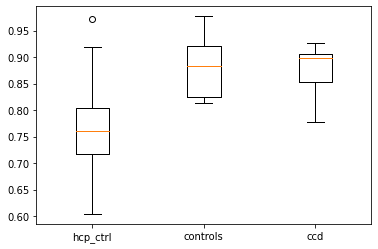

In [17]:
plt.boxplot((dev_test, dev_controls, dev_ccd),
            labels=('hcp_ctrl','controls', 'ccd'))

In [20]:
F,p = mannwhitneyu(dev_test, dev_controls)
print(p)
F,p = mannwhitneyu(dev_test, dev_ccd)
print(p)
F,p = mannwhitneyu(dev_controls, dev_ccd)
print(p)

6.428638482315627e-05
9.226493584385579e-05
0.5


### Latent space analysis - all data

In [46]:
X_all = np.array(list(deletion_hcp['latent']) + list(deletion_controls['latent']) + list(deletion_ccd_subjects['latent']))
labels = np.array(['hcp_test' for k in range(200)] + ['controls' for k in range(7)] + ['ccd_subjects' for k in range(7)])

In [47]:
reducer = umap.UMAP(random_state=14)
embedding = reducer.fit_transform(X_all)

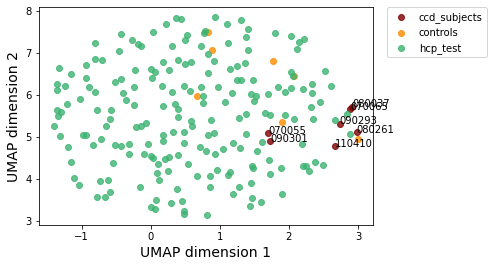

In [48]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 'ccd_subjects':'maroon'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.8)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
        ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [32]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_all)

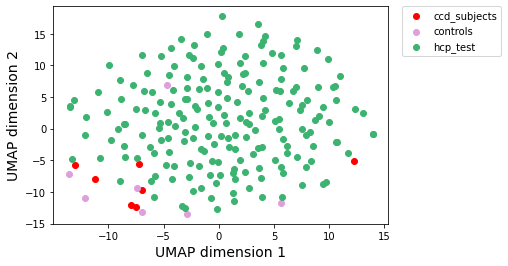

In [33]:
arr = X_embedded
color_dict = {'hcp_test':'mediumseagreen','controls': 'plum', 'ccd_subjects':'red'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Latent space analysis - CCD data

In [34]:
X_ccd = np.array(list(deletion_controls['latent']) + list(deletion_ccd_subjects['latent']))
labels_ccd = np.array(['controls' for k in range(7)] + ['ccd_subjects' for k in range(7)])

In [35]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_ccd)

/casa/home/.local/lib/python3.6/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


In [36]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(X_ccd)

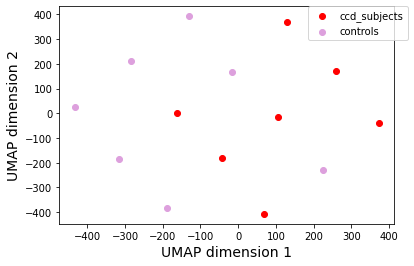

In [37]:
arr = X_embedded
color_dict = {'hcp_test':'mediumseagreen','controls': 'plum', 'ccd_subjects':'red'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_ccd):
    ix = np.where(labels_ccd == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

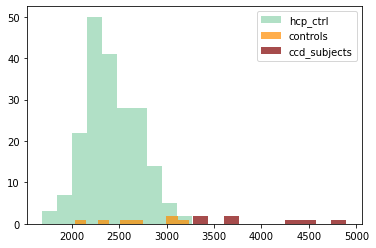

In [38]:
plt.subplot()
plt.hist(deletion_hcp.recon, color='mediumseagreen', alpha=0.4, label='hcp_ctrl',bins=10)
plt.hist(deletion_controls.recon, color='darkorange', alpha=0.7, label='controls', bins=10)
plt.hist(deletion_ccd_subjects.recon, color='maroon', alpha=0.7, label='ccd_subjects', bins=10)
plt.xlabel('')
plt.legend()

In [41]:
F,p = mannwhitneyu(deletion_hcp.recon, deletion_controls.recon)
print(p)
F,p = mannwhitneyu(deletion_controls.recon, deletion_ccd_subjects.recon)
print(p)
F,p = mannwhitneyu(deletion_hcp.recon, deletion_ccd_subjects.recon)
print(p)

0.03414193034081852
0.0010825146665191896
3.5542022882337206e-06


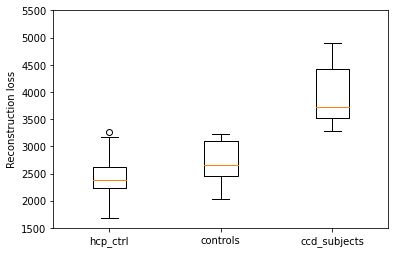

In [44]:
plt.boxplot((deletion_hcp.recon, deletion_controls.recon, deletion_ccd_subjects.recon),
            labels=('hcp_ctrl','controls','ccd_subjects'))
plt.ylabel('Reconstruction loss')
plt.ylim(1500,5500)
plt.rcParams['axes.grid'] = False

In [202]:
df_encoded.head()

,latent,loss,recon,input,sub,group
0,"[1.4097712, 0.93619686, -0.7659312, -2.1169956...",2494,2210,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,932554,hcp_test
1,"[2.0933332, -0.3032305, 0.18320197, -1.166268,...",2763,2473,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,387959,hcp_test
2,"[-0.6052267, 1.0967398, -0.4222953, 0.18244553...",2515,2217,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,887373,hcp_test
3,"[1.2632345, 0.6504203, -0.1568235, -0.24630514...",2957,2675,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,704238,hcp_test
4,"[0.7166091, -0.34431076, -0.9648081, -1.605272...",2895,2609,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,169040,hcp_test


### Reconstruction

In [144]:
deletion_ccd_subjects

,latent,loss,recon,input,sub
0,"[0.28942612, -0.21815628, -0.42906275, 2.66279...",4618,4355,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,110410
1,"[1.0623012, -0.19028115, 0.8006686, -0.9702803...",4007,3726,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,080037
2,"[1.4478563, -0.7983307, -0.25691378, -0.519837...",3569,3276,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,090293
3,"[2.035183, -1.5796027, 1.5886273, 1.1094865, 0...",5172,4896,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,080261
4,"[2.0480344, 1.5427313, -0.07445825, 0.38973776...",3726,3436,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,090301
5,"[2.3203354, -0.78961176, -1.247485, 1.3227624,...",3868,3600,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,070055
6,"[2.9638982, 1.7578396, 0.059830736, -0.5256784...",4790,4496,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,070065


In [143]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(len(deletion_ccd_subjects)):
    enc = deletion_ccd_subjects.latent[k]
    sub = deletion_ccd_subjects['sub'][k]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    out[out>0.5] = 1
    out[out<=0.5] = 0
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}{sub}_reconstruction.mesh")

In [147]:
input_data = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [155]:
len(input_data['ccd_subjects'])

7

In [161]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(len(deletion_ccd_subjects)):
    enc = deletion_ccd_subjects.latent[k]
    input_ccd = np.squeeze(input_data['ccd_subjects'][k])
    sub = deletion_ccd_subjects['sub'][k]
    
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    error = input_ccd - out
    error2 = out - input_ccd

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")

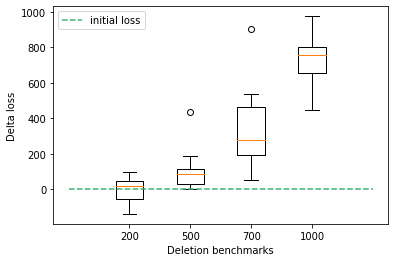

In [260]:
plt.boxplot((delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000),
            labels=('200','500','700','1000'))
plt.plot(['0','200','500','700','1000', '2000'], [0, 0, 0, 0, 0, 0], color='mediumseagreen', ls='--',
        label='initial loss')
plt.xlabel('Deletion benchmarks')
plt.ylabel('Delta loss')
plt.legend()